In [1]:
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
import fwiVis.fwiVis as fv


from math import cos, asin, sqrt
import re
import dask ## Needed to install, but didn't update env

import numpy as np
import geopandas as gpd

import pandas as pd
from pandas.errors import SettingWithCopyWarning
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr


from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings

import datetime
from datetime import date
import traceback

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore", category=SettingWithCopyWarning) 
# SettingWithCopyWarning
#UserWarning


In [2]:
### Get all IDs

flist = os.listdir("/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/")


import re

file_ids = [re.sub("([^a-zA-Z0-9].*)$", "", x) for x in flist]
file_ids = [re.sub("F", "", x) for x in file_ids]

file_ids = set(file_ids)
#file_ids
#print(len(file_ids))
#len(snap_2.index.unique()) ## Ok so the snapshot files are missing a fair amount.

In [45]:
# import time
# start = time.time()

# ## Make a spatial cheat-sheet so that I can spatially subset

# region =  "WesternUS_REDO"
# year = "2020"

# run_name = str(date.today())
# fid_latlon = [] # list of fire timeseries

# small_ids = file_ids
# #small_ids = ['9280', '9314']

# for n,i in enumerate(small_ids, start = 0):
#     try:
#         gdf = fv.load_large_fire(i, year = year, path_region= region)
#         lat = max(gdf[gdf.t == max(gdf.t)].lat)
#         lon = max(gdf[gdf.t == max(gdf.t)].lon)
        
#         fid_latlon.append([i, lat, lon])
#     except Exception as e:
#         print("Error with Fire: ",i,)
#         next
                              
    
#     if((n%5 == 0) | (n == (len(small_ids) -1))):
#         cheatsheet = pd.DataFrame(fid_latlon)
#         cheatsheet.to_csv("/projects/my-public-bucket/fire_spread/CHEATSHEET_" + region + "_" + year + "_" + run_name +".csv")

# # Grab Currrent Time After Running the Code
# end = time.time()

# #Subtract Start Time from The End Time
# total_time = end - start
# print("\n"+ str(total_time))
    
    
    

In [3]:
## Read in the cheatsheet 

cheatsheet = pd.read_csv("/projects/my-public-bucket/fire_spread/CHEATSHEET_WesternUS_REDO_2020_2023-03-06.csv")
cheatsheet = cheatsheet.rename(columns={"0":"fireID",
                          "1": "Lat", 
                          "2": "Lon"})
cheatsheet = gpd.GeoDataFrame(cheatsheet, geometry=gpd.points_from_xy(cheatsheet["Lon"], cheatsheet["Lat"]))

,Unnamed: 0,0,1,2
0,0,7851,32.943797,-108.251687
1,1,11467,44.462707,-121.577746
2,2,8390,38.067751,-120.702455
3,3,12513,45.811285,-106.067291
4,4,6911,35.865107,-114.957638
...,...,...,...,...
417,417,12021,34.792345,-113.246040
418,418,12454,47.367430,-106.845373
419,419,10585,35.387976,-120.429968
420,420,247,31.806548,-102.066733


In [4]:
## find all fireids in snapshot
pnw = gpd.read_file("/projects/my-public-bucket/fire_weather_vis/ref_data/NEON_DOMAIN/NEON_Domains.shp")# quickly subset by state to avoid computational stuff
pnw = pnw[pnw.DomainID == 16]

join = gpd.tools.sjoin(cheatsheet,pnw, predicate="within")
ids = join.fireID.unique()
## Get the IDs that are in the shapefile

/tmp/ipykernel_8203/672423951.py:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  join = gpd.tools.sjoin(cheatsheet,pnw, predicate="within")


In [4]:
ids

array([13203, 12959, 13051, 10491, 12984, 12961, 12953, 10532, 12981,
       10523, 13132, 13066, 13201, 13069, 12941, 12380, 12963, 13042,
       12985, 11440, 10261, 13525, 12960, 12779])

In [5]:
imerge_hr = xr.open_dataset("s3://veda-data-store-staging/EIS/zarr/FWI-GEOS-5-Hourly", engine="zarr")

In [8]:
#imerge_hr["GEOS-5_FWI"].to_dataframe
imerge_hr

# times = full_fr["t"].loc[full_fr["spread_line"] ]
# times_not = full_fr["t"].loc[full_fr["spread_line"] == False]
# times_not = times_not[(times_not.dt.hour == 13) & (times_not.dt.minute == 30)]


<xarray.Dataset>
Dimensions:      (time: 26880, lat: 533, lon: 1152)
Coordinates:
  * lat          (lat) float64 -58.0 -57.75 -57.5 -57.25 ... 74.5 74.75 75.0
  * lon          (lon) float64 -180.0 -179.7 -179.4 -179.1 ... 179.1 179.4 179.7
  * time         (time) datetime64[ns] 2020-01-01 ... 2023-01-24T23:00:00
Data variables:
    GEOS-5_FFMC  (time, lat, lon) float32 ...
    GEOS-5_FWI   (time, lat, lon) float32 ...
    GEOS-5_ISI   (time, lat, lon) float32 ...
Attributes: (12/46)
    Center:              NASA GISS / Columbia University
    Center::             center
    DCDryStartFactor:    5.0
    DCDryStartFactor::   DC number of days since precip mult factor for dry s...
    DCStart:             15.0
    DCStart::            DC starting value after wet winter
    ...                  ...
    snowCoverDaysCalc:   60.0
    snowCoverDaysCalc::  Number of days prior to spring over which to determi...
    startShutDays:       2.0
    startShutDays::      Number of previous days over which to consider start...
    tempThresh:          6.0
    tempThresh::         Temp thresh (C) to define start and end of winter

In [9]:
gdf = fv.load_large_fire('9677', year = "2020", path_region="WesternUS_REDO")

/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:426: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:427: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


In [10]:
imerge = xr.open_dataset("s3://veda-data-store-staging/EIS/zarr/GEOS5_FWI_GPM_LATE_v5_Daily.zarr", engine="zarr")
#imerge_year = imerge['GPM.LATE.v5_FWI'].loc["2020-01-01":"2020-10-31"]

In [11]:
imerge.rio.write_crs("epsg:4326", inplace=True)
imerge.rio.set_spatial_dims(x_dim = "lon", y_dim = "lat", inplace = True)
#vars = ["GPM.LATE.v5_ISI","GPM.LATE.v5_FWI", "GPM.LATE.v5_FFMC"]
#imerge[vars].rio.set_spatial_dims(x_dim = "lon", y_dim = "lat", inplace = True)

<xarray.Dataset>
Dimensions:           (time: 3250, lat: 1330, lon: 3600)
Coordinates:
  * lat               (lat) float64 -57.95 -57.85 -57.75 ... 74.75 74.85 74.95
  * lon               (lon) float64 -179.9 -179.8 -179.8 ... 179.8 179.9 179.9
  * time              (time) datetime64[ns] 2014-05-01 2014-05-02 ... 2023-03-24
    spatial_ref       int64 0
Data variables:
    GPM.LATE.v5_BUI   (time, lat, lon) float32 ...
    GPM.LATE.v5_DC    (time, lat, lon) float32 ...
    GPM.LATE.v5_DMC   (time, lat, lon) float32 ...
    GPM.LATE.v5_DSR   (time, lat, lon) float32 ...
    GPM.LATE.v5_FFMC  (time, lat, lon) float32 ...
    GPM.LATE.v5_FWI   (time, lat, lon) float32 ...
    GPM.LATE.v5_ISI   (time, lat, lon) float32 ...
Attributes: (12/46)
    Center:              NASA GISS / Columbia University
    Center::             center
    DCDryStartFactor:    5.0
    DCDryStartFactor::   DC number of days since precip mult factor for dry s...
    DCStart:             15.0
    DCStart::            DC starting value after wet winter
    ...                  ...
    snowCoverDaysCalc:   60.0
    snowCoverDaysCalc::  Number of days prior to spring over which to determi...
    startShutDays:       2.0
    startShutDays::      Number of previous days over which to consider start...
    tempThresh:          6.0
    tempThresh::         Temp thresh (C) to define start and end of winter

In [35]:
#for i in ids:
def imerge_merge(gdf, year = "2020", path_region = "WesternUS_REDO", add_anomolies = False, time_freq = "hourly", **kwargs):
    
    ## Read in IMERGE (is this the best place for this?)
    
    if (time_freq == "daily"):
        imerge = xr.open_dataset("s3://veda-data-store-staging/EIS/zarr/GEOS5_FWI_GPM_LATE_v5_Daily.zarr", engine="zarr")
        imerge.rio.write_crs("epsg:4326", inplace=True)
        imerge.rio.set_spatial_dims(x_dim = "lon", y_dim = "lat", inplace = True)
    if (time_freq == "hourly"):
        imerge = xr.open_dataset("s3://veda-data-store-staging/EIS/zarr/FWI-GEOS-5-Hourly", engine="zarr")
        imerge = imerge["GEOS-5_FWI"]
        imerge.rio.write_crs("epsg:4326", inplace=True)
        imerge.rio.set_spatial_dims(x_dim = "lon", y_dim = "lat", inplace = True)
        

    ## Get imerge -- Need to do on whole area? How manke more computationally efficient?
    final_perimeter = max(gdf[gdf.t == max(gdf.t)].geometry)
    #print(final_perimeter.envelope.exterior.coords.xy)
    lons = final_perimeter.envelope.exterior.coords.xy[0]
    lats = final_perimeter.envelope.exterior.coords.xy[1]
    img_clip = imerge.rio.clip_box(minx = min(lons), miny = min(lats), maxx=max(lons), maxy = max(lats), auto_expand= True)
    
    if(add_anomolies):
        img_clip = fv.imerge_climate(img_clip ,clim = ["rank", "anomolie","rank_anomolie"], var = ["FWI"])
    
    img_clip = img_clip.sel(time = slice(min(gdf.t), max(gdf.t))).mean(dim = ["lat", "lon"])
    img_clip = img_clip.to_dataframe()
    img_clip.drop(columns = "spatial_ref", inplace = True)
    img_clip.dropna(inplace = True)
    
    #gdf["fireID"] = id
    gdf = gdf.rename(columns = {"t" : "time"})
    gdf['time'] = gdf['time'].astype('datetime64[ns]')
    full = pd.merge(gdf,img_clip, on = "time", how = "outer")
    full = full.rename(columns = {"time": "t"}) ## Seems silly but I cant get the img_clip to convert it's name
    
    return(full)

In [39]:
#full = imerge_merge("6610", "2020", "WesternUS")

#gdf = fv.load_large_fire("6610", year = "2020", path_region= "WesternUS")
#gdf = gdf.sort_values(by = ["t"])

In [232]:
#gdf

In [14]:
#test = test.sort_values(by = ["t"])
#plt.scatter(test.t, test.farea)

In [15]:
#plt.scatter(test.t, test["GPM.LATE.v5_FWI"])


In [40]:
### Find differences, and "spread_lines" (SAME AS SPREAD DAYS WHEN MET IS DAILY)


# ### Fire area differnce
# full_d = full[full.t.dt.hour > 0] ## Daytime
# full_n = full[full.t.dt.hour < 12] ## Nighttime

# fulls = [full_n, full_d]
# labels = ["Night", "Day"]

# for f,l in zip(fulls, labels):
    
#     f["fline_diff"] = f.flinelen.diff()
#     f["farea_diff"] = f.farea.diff()
    
#     max_spread = max(f.fline_diff[f.fline_diff.notna()])
#     f["spread_line"] = ((f["farea_diff"] > 0) & (f["farea_diff"] > (max_spread * 0.80)))
#     f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "other"
#     #f["spread_line" + l] = f.spread_line
#     f.rename(columns = {"spread_line": "spread_line" + l})
#     #plt.scatter(f.t, f.farea, c = f.spread_line)
    
# fire = pd.merge(full_n,full_d, on = ['n_pixels', 'n_newpixels', 'farea', 'fperim', 'flinelen', 'duration',
#        'pixden', 'meanFRP', 't', 'geometry', 'lon', 'lat', 'fireID',
#        'GPM.LATE.v5_BUI', 'GPM.LATE.v5_DC', 'GPM.LATE.v5_DMC',
#        'GPM.LATE.v5_DSR', 'GPM.LATE.v5_FFMC', 'GPM.LATE.v5_FWI',
#        'GPM.LATE.v5_ISI', 'FWI_anomolie', 'FWI_rank', 'FWI_rank_anomolies', "spread_line", "fline_diff","farea_diff" ], how = "outer")
# fire = fire.sort_values(by = ["t"])

In [66]:
# type(full)

geopandas.geodataframe.GeoDataFrame

In [13]:
## Make into a function

def get_gpm_spread(full, pct_max_spread = 0.20):
    '''
    Finds "spread_days" and "non_spread_days" for fire. 
    
    INPUTS:
        
        full (GeoDataFrame): GDF with farea. Output from Imerge-merge
        pct_max_spread (float): Percentage of biggest increase in fire area that should count as a "spread day"
    
    '''
    
    cols = list(full.columns.values)
    
    full_d = full[full.t.dt.hour > 0] ## Daytime
    full_d = full_d.sort_values(by = ["t"]) #--- Need to sort by time, will otherwise calcualete diffs based on weird sorting
    full_n = full[full.t.dt.hour < 12] ## Nighttime
    full_n = full_n.sort_values(by = ["t"])

    fulls = [full_n, full_d]
    labels = ["Night", "Day"]

    for f,l in zip(fulls, labels):
    
        f["fline_diff"] = f.flinelen.diff()
        f["farea_diff"] = f.farea.diff()

        max_spread = max(f.fline_diff[f.fline_diff.notna()]) ## by calculating a different max for daytime vs nighttime, can get a step change in one that doesn't qualify, but would qaulify for the other. 
        
        f["spread_line"] = ((f["farea_diff"] > 0) & (f["farea_diff"] > (max_spread * pct_max_spread)))
        f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "other"
        f["spread_line" + l] = f.spread_line
        #f.rename(columns = {"spread_line": "spread_line" + l})
        #plt.scatter(f.t, f.farea, c = f.spread_line)
    
    cols = cols + ["spread_line", "farea_diff", "fline_diff"]
    fire = pd.merge(full_n,full_d, on = cols, how = "outer")
    fire = fire.sort_values(by = ["t"])
    
    max_spread = max(fire.fline_diff[fire.fline_diff.notna()]) ## Recalulating max and spread days for overall maximum. 
    fire["spread_day"] = ((fire["farea_diff"] > 0) & (fire["farea_diff"] > (max_spread * pct_max_spread)))
    fire.spread_day[fire.t == min(fire.t)] = 2
    
    return(fire)

def get_spread_period(full_fr, time_of_interest = 12,  hours_before = 0, lags = [-2,-4,-12,-24,-48]):
    
    lables = ["Night", "Day"]
    for i in lables:

        times = full_fr["t"].loc[full_fr["spread_line" + i] == True] ## Is this acurate given the definitions above? 
        times_not = full_fr["t"].loc[full_fr["spread_line" + i] == False]
        #times_not = times_not[(times_not.dt.hour == 13) & (times_not.dt.minute == 30)]

        full_fr["spread_period"+ i] = np.nan

        for t in times:
            times_start = t - np.timedelta64((time_of_interest + hours_before), "h")
            times_end = t - np.timedelta64((hours_before), "h")
            full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = True


        for l in times_not:
            times_start = l - np.timedelta64((time_of_interest + hours_before), "h")
            times_end = l - np.timedelta64((hours_before), "h")
            full_fr["spread_period"+ i][(full_fr["t"] >= times_start) & (full_fr["t"] <= times_end)] = False

        for lag in lags:
            full_fr["spread_period"+ i +"_lag_" + str(lag)] = full_fr["spread_period"+ i].shift(lag)

    return(full_fr)

    

In [454]:
#fire = get_gpm_spread(full)

In [34]:
#?pd.concat
#small_ids = ["5243", "6588"]
#allfr = [np.repeat(np.nan, len(small_ids), axis=0)]
#allfr[0][1]
# ids

region =  "WesternUS_REDO"
year = "2020"
i = "7656"

gdf = fv.load_large_fire(i, year = year, path_region= region)

# full = gdf

# cols = list(full.columns.values)

# full_d = full[full.t.dt.hour > 0] ## Daytime
# full_d = full_d.sort_values(by = ["t"]) #--- Need to sort by time, will otherwise calcualete diffs based on weird sorting
# full_n = full[full.t.dt.hour < 12] ## Nighttime
# full_n = full_n.sort_values(by = ["t"])

# fulls = [full_n, full_d]
# labels = ["Night", "Day"]

# for f,l in zip(fulls, labels):

#     f["fline_diff"] = f.flinelen.diff()
#     f["farea_diff"] = f.farea.diff()

#     max_spread = max(f.fline_diff[f.fline_diff.notna()]) ## by calculating a different max for daytime vs nighttime, can get a step change in one that doesn't qualify, but would qaulify for the other. 

#     f["spread_line"] = ((f["farea_diff"] > 0) & (f["farea_diff"] > (max_spread * pct_max_spread)))
#     f.spread_line[f.t == min(f.t)] = 2 # First detection need special catagory. Maybe always counts as spread day, maybe "other"
#     f["spread_line" + l] = f.spread_line
#     #f.rename(columns = {"spread_line": "spread_line" + l})
#     #plt.scatter(f.t, f.farea, c = f.spread_line)

# cols = cols + ["spread_line", "farea_diff", "fline_diff"]
# fire = pd.merge(full_n,full_d, on = cols, how = "outer")
# fire = fire.sort_values(by = ["t"])

# max_spread = max(fire.fline_diff[fire.fline_diff.notna()]) ## Recalulating max and spread days for overall maximum. 
# fire["spread_day"] = ((fire["farea_diff"] > 0) & (fire["farea_diff"] > (max_spread * pct_max_spread)))
# fire.spread_day[fire.t == min(fire.t)] = 2
# #full = get_gpm_spread(gdf)

In [52]:
#manyfr = pd.read_csv("/projects/my-public-bucket/fire_spread/WesternUS_2020_2023-02-25attempt_at_production.csv")
#manyfr = manyfr[manyfr.fireID == 4900]

In [1]:
#manyfr.fireID.unique()
#manyfr["fireID"]

NameError: name 'manyfr' is not defined

In [40]:
### Put all together into horrible for-loop
#small_ids = ["7656", "8335"]
#small_ids = file_ids
#small_ids = ids.astype("str")
small_ids = ids.astype("str")

import time
from datetime import date

#import logging
#logging.basicConfig(level=logging.ERROR)
#logger = logging.getLogger(__name__)


# Grab Currrent Time Before Running the Code
start = time.time()

################# Horrible for loop ##################
sub_region = "PNW"
region =  "WesternUS_REDO"
year = "2020"

run_name = str(date.today()) + "region_workflow_hourly"
allfr = [] # list of fire timeseries
bad_ids = [] # list of IDs that failed due to error

for n,i in enumerate(small_ids, start = 0):
    #print(n)
    #print(i)

#     full = imerge_merge(i, "2020", "WesternUS")
#     fire = get_gpm_spread(full)

#     #fire = pd.Data
#     allfr.append(fire)
        
    try:
        raw_fire = fv.load_large_fire(i, year = year, path_region= region)
        raw_fire["fireID"] = str(i)
        full = get_gpm_spread(raw_fire)
    except Exception as e:
        print("Error at imerge_merge with Fire: ",i,)
        bad_log = traceback.format_exc(limit = 40) # Get log of error
        print(bad_log)
        bad_ids.append(
        {
            "fireID": i, 
            "func_failed": "imerge_merge",
            "log": bad_log
        }
        )
        #logger.debug(traceback.format_exc())
        next
    else:
        try:
            uncorrected_fire = imerge_merge(full)
            #print(uncorrected_fire.fireID)
            fire = get_spread_period(uncorrected_fire)
            #print(fire.fireID)
        except Exception as e:
            print("Error in calculating spread days in Fire: ",i)
            bad_log = traceback.format_exc(limit = 40) # Get log of error
            print(bad_log)
            bad_ids.append(
            {
                "fireID": i, 
                "func_failed": "get_gpm_spread",
                "log": bad_log
            }
            )
            #logger.debug(traceback.format_exc())
            next
        #fire = pd.Data
        allfr.append(fire)
    if((n%5 == 0) | (n == (len(small_ids) -1))):
        print("")
        manyfr = gpd.GeoDataFrame(pd.concat(allfr, ignore_index=True), crs= fire.crs)
        manyfr.to_csv("/projects/my-public-bucket/fire_spread/" + region + "_" + sub_region + "_" + year + "_" + run_name +".csv")
        
        debug = pd.DataFrame(bad_ids)
        debug.to_csv("/projects/my-public-bucket/fire_spread/DEBUG_" + region + "_" + sub_region + "_" + year + "_" + run_name + ".csv") ## Need to generate custom path

# Grab Currrent Time After Running the Code
end = time.time()

#Subtract Start Time from The End Time
total_time = end - start
print("\n"+ str(total_time))

/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:426: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:427: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y


/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:426: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:427: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:426: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:427: UserWarning: Geometry is in a geographi

/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:426: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:427: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:426: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:427: UserWarning: Geometry is in a geographi

/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:426: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:427: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:426: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:427: UserWarning: Geometry is in a geographi

/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:426: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:427: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:426: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:427: UserWarning: Geometry is in a geographi

Error at imerge_merge with Fire:  12985
Traceback (most recent call last):
  File "/tmp/ipykernel_337/3746200917.py", line 40, in <module>
    full = get_gpm_spread(raw_fire)
  File "/tmp/ipykernel_337/1014166134.py", line 29, in get_gpm_spread
    max_spread = max(f.fline_diff[f.fline_diff.notna()]) ## by calculating a different max for daytime vs nighttime, can get a step change in one that doesn't qualify, but would qaulify for the other.
ValueError: max() arg is an empty sequence



/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:426: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:427: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:426: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:427: UserWarning: Geometry is in a geographi

/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:426: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:427: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lat'] = gdf.centroid.y
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:426: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['lon'] = gdf.centroid.x
/projects/my-public-bucket/fire_weather_vis/base-fwi-vis/fwiVis/fwiVis.py:427: UserWarning: Geometry is in a geographi



335.57976841926575


In [39]:
manyfr.fireID.unique()

array(['7656', nan, '8335'], dtype=object)

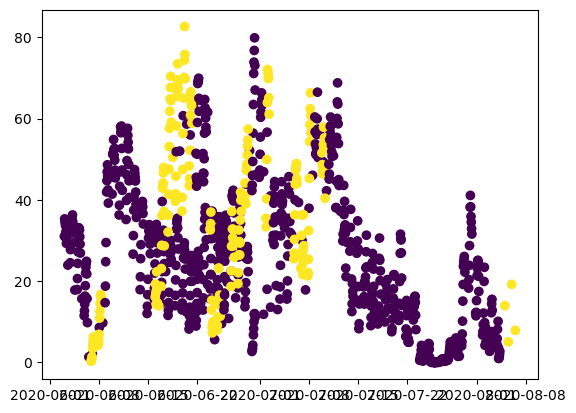

In [18]:
#manyfr.spread_periodDay.unique()
plt.scatter(manyfr.t, manyfr['GEOS-5_FWI'], c= manyfr["spread_periodDay_lag_-48"])

In [31]:
manyfr.fireID

0       <built-in function id>
1       <built-in function id>
2       <built-in function id>
3       <built-in function id>
4       <built-in function id>
                 ...          
1953                       NaN
1954                       NaN
1955                       NaN
1956                       NaN
1957                       NaN
Name: fireID, Length: 1958, dtype: object

In [22]:
### Dask try except function
# def crunch_spread(i):
    
#     try:
#         full = imerge_merge(i)
#     except Exception as e:
#         print("Error at imerge_merge with Fire: ",i,)
#         bad_log = traceback.format_exc(limit = 40) # Get log of error
#         return(
#         {
#             "fireID": i, 
#             "func_failed": "imerge_merge",
#             "log": bad_log
#         })
        

#     else:
#         try:
#             fire = get_gpm_spread(full)
#         except Exception as e:
#             print("Error in calculating spread days in Fire: ",i)
#             bad_log = traceback.format_exc(limit = 40) # Get log of error

#             return(
#             {
#                 "fireID": i, 
#                 "func_failed": "get_gpm_spread",
#                 "log": bad_log
#             })
#         return(fire)
            

'Traceback (most recent call last):\n  File "/tmp/ipykernel_938/723151245.py", line 37, in <module>\n    gdf = fv.load_large_fire(i, year = year, path_region= path_region)\nNameError: name \'path_region\' is not defined\n'

In [10]:
### Put all together into horrible for-loop

small_ids = file_ids

import time
from datetime import date

In [11]:
import time
from datetime import date

start = time.time()
################# Horrible for loop ##################

region =  "WesternUS"
year = "2020"

run_name = str(date.today()) + "attempt_at_production"
allfr = [] # list of fire timeseries
bad_ids = [] # list of IDs that failed due to error

for n,i in enumerate(small_ids, start = 0):
    print(n)
    fire = crunch_spread(i)
#     try:
#         full = dask.delayed(imerge_merge)(i)
#     except Exception as e:
#         print("Error at imerge_merge with Fire: ",i,)
#         bad_log = traceback.format_exc(limit = 40) # Get log of error
#         bad_ids.append(
#         {
#             "fireID": i, 
#             "func_failed": "imerge_merge",
#             "log": bad_log
#         }
#         )
#         #logger.debug(traceback.format_exc())
#         next
#     else:
#         try:
#             fire = dask.delayed(get_gpm_spread)(full)
#         except Exception as e:
#             print("Error in calculating spread days in Fire: ",i)
#             bad_log = traceback.format_exc(limit = 40) # Get log of error

#             bad_ids.append(
#             {
#                 "fireID": i, 
#                 "func_failed": "get_gpm_spread",
#                 "log": bad_log
#             }
#             )
#             #logger.debug(traceback.format_exc())
#             next
#         #fire = pd.Data

    allfr.append(fire)
        
allfr = dask.compute(*allfr)
#bad_ids = dask.compute(*bad_ids)

manyfr = gpd.GeoDataFrame(pd.concat(allfr, ignore_index=True), crs= fire.crs)
manyfr.to_csv("/projects/my-public-bucket/fire_spread/" + region + "_" + year + "_" + run_name +".csv")

debug = pd.DataFrame(bad_ids)
debug.to_csv("/projects/my-public-bucket/fire_spread/DEBUG_" + region + "_" + year + "_" + run_name + ".csv")

end = time.time()
total_time = end - start
print("\n"+ str(total_time))


0


NameError: name 'crunch_spread' is not defined

In [83]:
type(manyfr.fireID[0])

numpy.int64

In [47]:
manyfr = gpd.GeoDataFrame(pd.concat(allfr, ignore_index=True), crs= fire.crs)
  

405


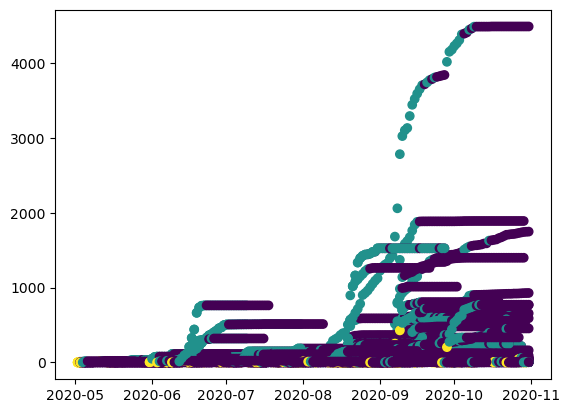

In [48]:
plt.scatter(manyfr.t, manyfr.farea, c = manyfr.spread_lineNight)
print(len(manyfr.fireID.unique()))

test = manyfr[manyfr.fireID == '5243']

In [60]:
manyfr = manyfr.sort_values(by = ["t"])

#manyfr.to_csv("/projects/my-public-bucket/fire_spread/oregon_sample_test.csv")
#manyfr = pd.read_csv("/projects/my-public-bucket/fire_spread/oregon_sample_test.csv", parse_dates=['t'])

In [50]:
max(manyfr["GPM.LATE.v5_FWI"].dropna())

145.83660888671875

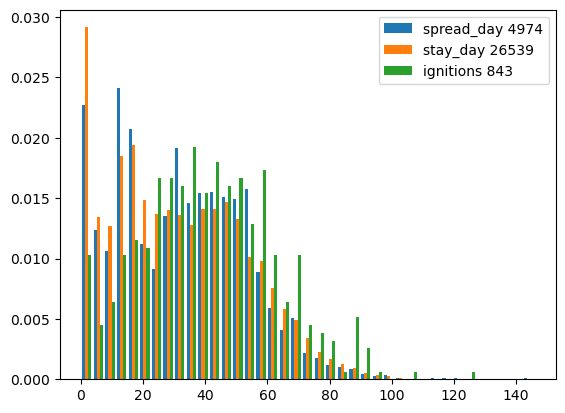

In [51]:
#plt.hist(manyfr["GPM.LATE.v5_FWI"], c = manyfr.spread_line )

bins = np.linspace(0, max(manyfr["GPM.LATE.v5_FWI"].dropna()), 40)
#bins

spread_n = str(len(manyfr["GPM.LATE.v5_FWI"][manyfr.spread_line == 1]))
n_spread_n = str(len(manyfr["GPM.LATE.v5_FWI"][manyfr.spread_line == 0]))
ig_n = str(len(manyfr["GPM.LATE.v5_FWI"][manyfr.spread_line == 2]))

plt.hist([manyfr["GPM.LATE.v5_FWI"][manyfr.spread_line == 1], manyfr["GPM.LATE.v5_FWI"][manyfr.spread_line == 0], manyfr["GPM.LATE.v5_FWI"][manyfr.spread_line == 2]], bins, label=['spread_day' + " " + spread_n, 'stay_day' + " " + n_spread_n, "ignitions" + " " + ig_n],  density = True)
plt.legend(loc='upper right')
plt.show()

In [106]:
#plt.scatter(manyfr.t, manyfr["GPM.LATE.v5_FWI"], c = manyfr.spread_line)
manyfr.columns

Index(['Unnamed: 0', 'n_pixels', 'n_newpixels', 'farea', 'fperim', 'flinelen',
       'duration', 'pixden', 'meanFRP', 't', 'geometry', 'lon', 'lat',
       'fireID', 'GPM.LATE.v5_BUI', 'GPM.LATE.v5_DC', 'GPM.LATE.v5_DMC',
       'GPM.LATE.v5_DSR', 'GPM.LATE.v5_FFMC', 'GPM.LATE.v5_FWI',
       'GPM.LATE.v5_ISI', 'fline_diff', 'farea_diff', 'spread_line',
       'spread_lineNight', 'spread_lineDay', 'spread_day'],
      dtype='object')

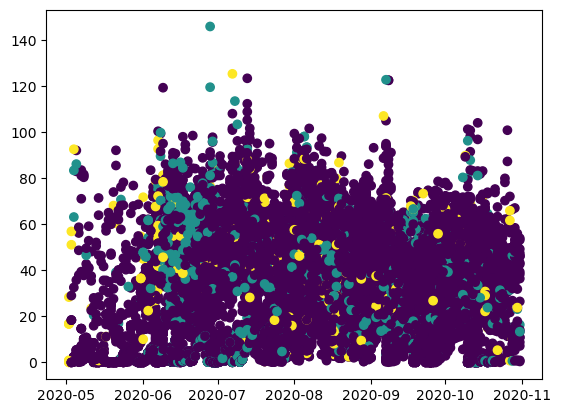

In [56]:
plt.scatter(manyfr.t, manyfr["GPM.LATE.v5_FWI"], c = manyfr.spread_line)

In [192]:
manyfr.columns

Index(['n_pixels', 'n_newpixels', 'farea', 'fperim', 'flinelen', 'duration',
       'pixden', 'meanFRP', 't', 'geometry', 'lon', 'lat', 'fireID',
       'GPM.LATE.v5_BUI', 'GPM.LATE.v5_DC', 'GPM.LATE.v5_DMC',
       'GPM.LATE.v5_DSR', 'GPM.LATE.v5_FFMC', 'GPM.LATE.v5_FWI',
       'GPM.LATE.v5_ISI', 'FWI_anomolie', 'FWI_rank', 'FWI_rank_anomolies',
       'fline_diff', 'farea_diff', 'spread_line'],
      dtype='object')

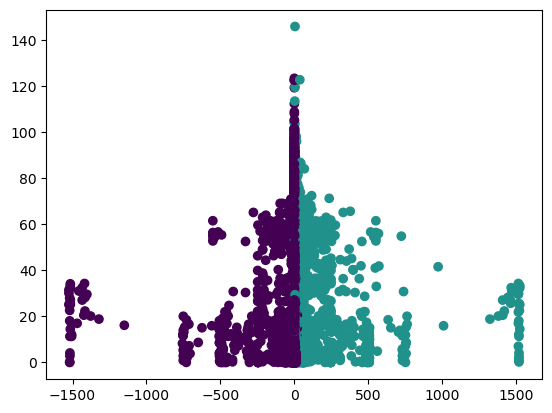

In [57]:
plt.scatter(manyfr.farea_diff, manyfr["GPM.LATE.v5_FWI"], c = manyfr.spread_line)

In [58]:
max_fwi = max(manyfr["GPM.LATE.v5_FWI"].dropna())

In [172]:
manyfr[manyfr["GPM.LATE.v5_FWI"] == max_fwi ].t

843   2020-09-07
Name: t, dtype: datetime64[ns]

Text(0, 0.5, 'FWI')

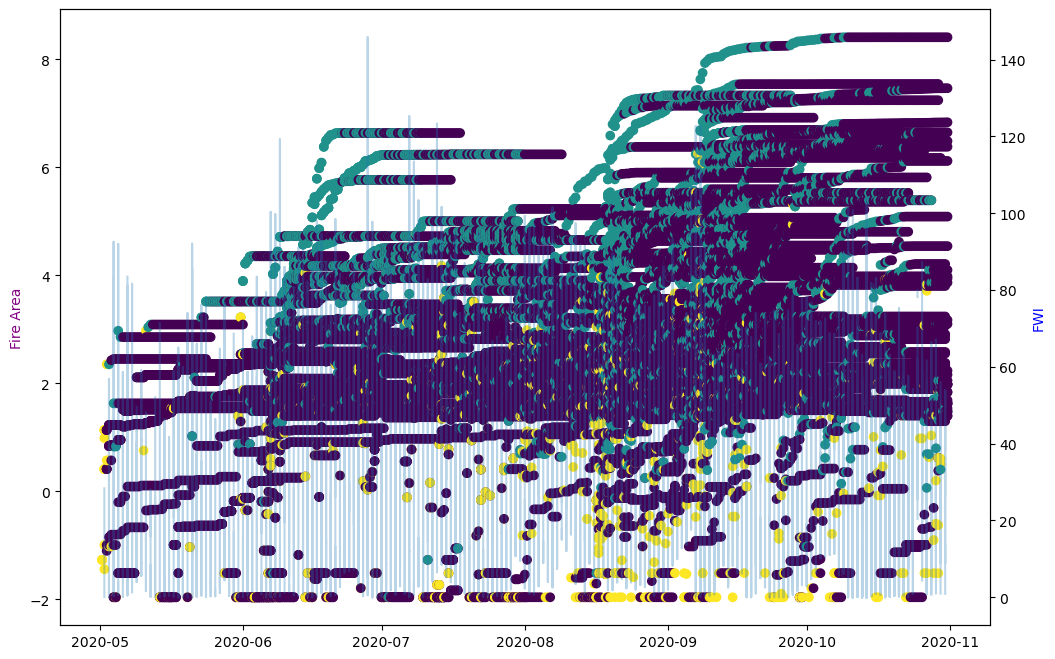

In [61]:


fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(manyfr.t, np.log(manyfr.farea), c = manyfr.spread_line)
ax.set_ylabel("Fire Area", color = "purple")
ax2=ax.twinx()
ax2.plot(manyfr.t, manyfr["GPM.LATE.v5_FWI"], alpha = 0.3)

ax2.set_ylabel("FWI",color="blue")


Text(0, 0.5, 'FWI')

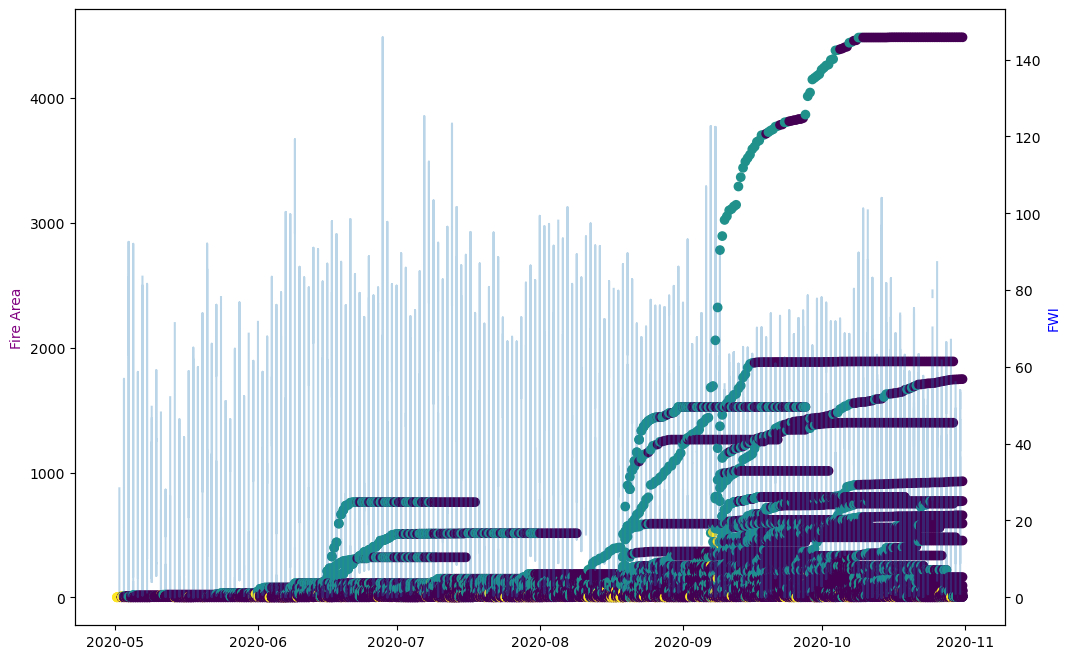

In [62]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(manyfr.t, manyfr.farea, c = manyfr.spread_line)
ax.set_ylabel("Fire Area", color = "purple")
ax2=ax.twinx()
ax2.plot(manyfr.t, manyfr["GPM.LATE.v5_FWI"], alpha = 0.3)

ax2.set_ylabel("FWI",color="blue")

Text(0, 0.5, 'FWI')

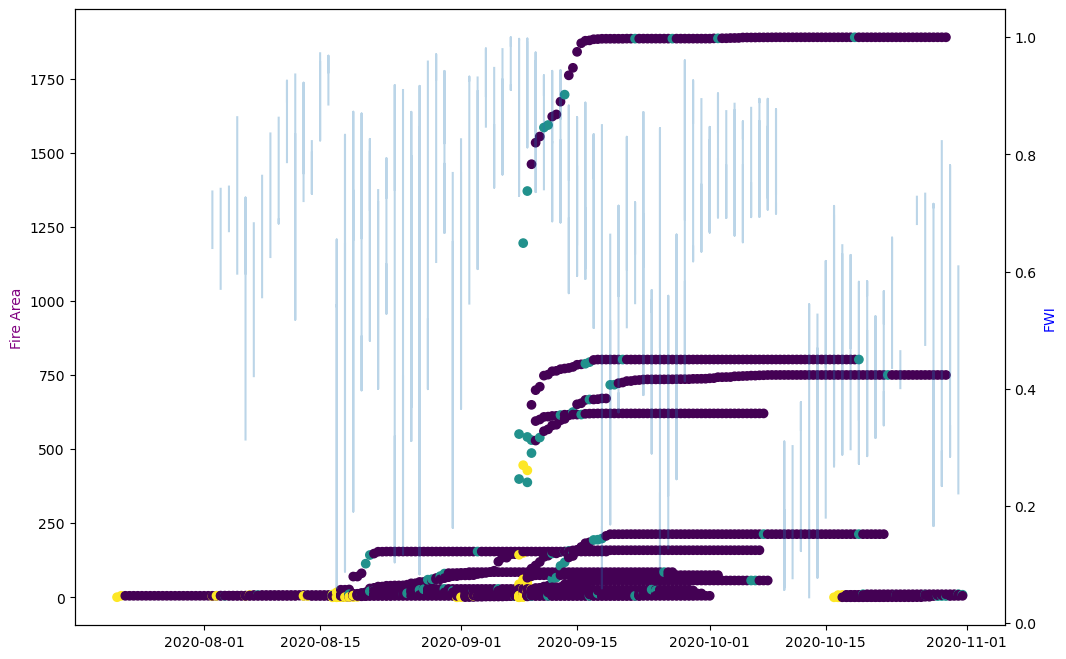

In [208]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(manyfr.t, manyfr.farea, c = manyfr.spread_line)
ax.set_ylabel("Fire Area", color = "purple")
ax2=ax.twinx()
ax2.plot(manyfr.t, manyfr.FWI_rank, alpha = 0.3)

ax2.set_ylabel("FWI",color="blue")

In [68]:
# fig, ax = plt.subplots(figsize=(12,8))
# ax.scatter(manyfr.t, manyfr.farea, c = manyfr.spread_line)
# ax.set_ylabel("Fire Area", color = "purple")
# ax2=ax.twinx()
# ax2.plot(manyfr.t, manyfr['GPM.LATE.v5_FFMC'], alpha = 0.3)

# ax2.set_ylabel("FWI",color="blue")

/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


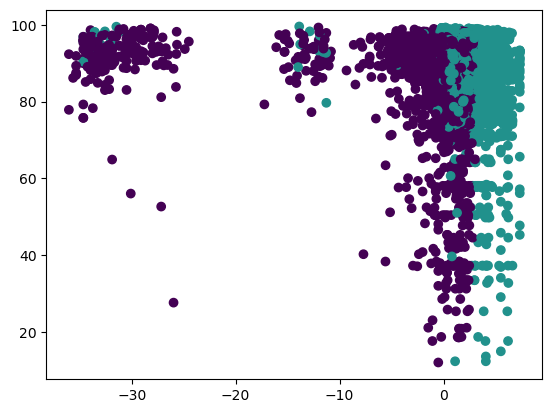

In [69]:
plt.scatter(np.log(manyfr.farea_diff), manyfr['GPM.LATE.v5_FFMC'], c = manyfr.spread_line)

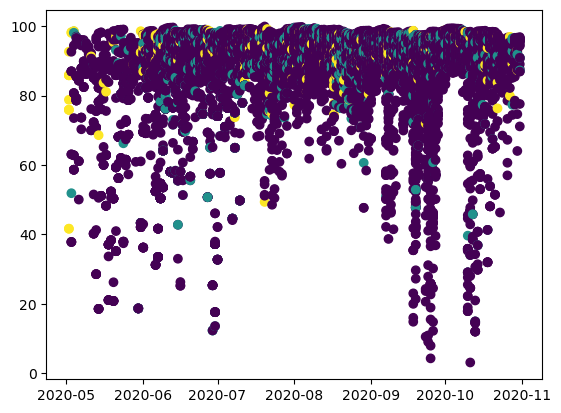

In [63]:
plt.scatter(manyfr.t, manyfr['GPM.LATE.v5_FFMC'], c = manyfr.spread_line)

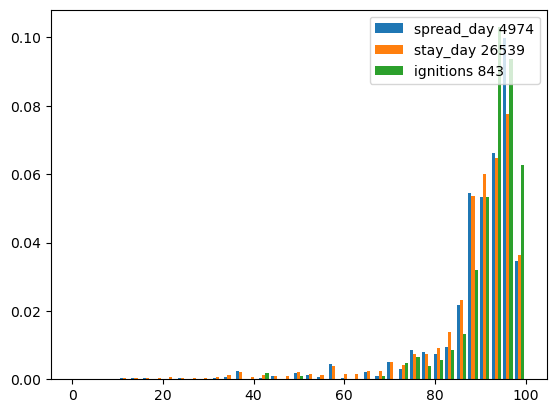

In [64]:

bins = np.linspace(0, max(manyfr["GPM.LATE.v5_FFMC"].dropna()), 40)
#bins

spread_n = str(len(manyfr["GPM.LATE.v5_FFMC"][manyfr.spread_line == 1]))
n_spread_n = str(len(manyfr["GPM.LATE.v5_FFMC"][manyfr.spread_line == 0]))
ig_n = str(len(manyfr["GPM.LATE.v5_FFMC"][manyfr.spread_line == 2]))

plt.hist([manyfr["GPM.LATE.v5_FFMC"][manyfr.spread_line == 1], manyfr["GPM.LATE.v5_FFMC"][manyfr.spread_line == 0], manyfr["GPM.LATE.v5_FFMC"][manyfr.spread_line == 2]], bins, label=['spread_day' + " " + spread_n, 'stay_day' + " " + n_spread_n, "ignitions" + " " + ig_n],  density = True)
plt.legend(loc='upper right')
plt.show()

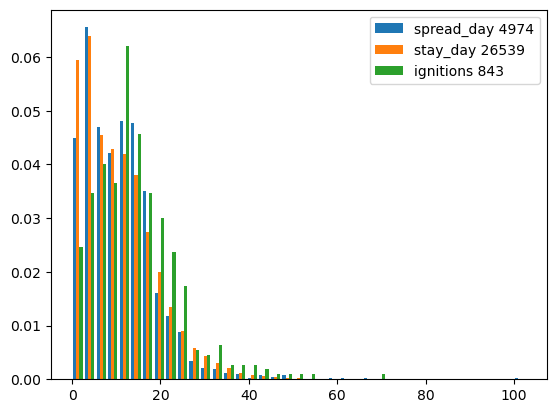

In [70]:
bins = np.linspace(0, max(manyfr["GPM.LATE.v5_ISI"].dropna()), 40)
#bins

spread_n = str(len(manyfr["GPM.LATE.v5_ISI"][manyfr.spread_line == 1]))
n_spread_n = str(len(manyfr["GPM.LATE.v5_ISI"][manyfr.spread_line == 0]))
ig_n = str(len(manyfr["GPM.LATE.v5_ISI"][manyfr.spread_line == 2]))

plt.hist([manyfr["GPM.LATE.v5_ISI"][manyfr.spread_line == 1], manyfr["GPM.LATE.v5_ISI"][manyfr.spread_line == 0], manyfr["GPM.LATE.v5_ISI"][manyfr.spread_line == 2]], bins, label=['spread_day' + " " + spread_n, 'stay_day' + " " + n_spread_n, "ignitions" + " " + ig_n],  density = True)
plt.legend(loc='upper right')
plt.show()

In [67]:
# bins = np.linspace(0, max(manyfr["FWI_rank"].dropna()), 40)
# #bins

# spread_n = str(len(manyfr["FWI_rank"][manyfr.spread_line == 1]))
# n_spread_n = str(len(manyfr["FWI_rank"][manyfr.spread_line == 0]))
# ig_n = str(len(manyfr["FWI_rank"][manyfr.spread_line == 2]))

# plt.hist([manyfr["FWI_rank"][manyfr.spread_line == 1], manyfr["FWI_rank"][manyfr.spread_line == 0], manyfr["FWI_rank"][manyfr.spread_line == 2]], bins, label=['spread_day' + " " + spread_n, 'stay_day' + " " + n_spread_n, "ignitions" + " " + ig_n],  density = True)
# plt.legend(loc='upper right')
# plt.show()

In [83]:
## Percentage of these 30 fires burn area from spread days
#final_a = ["Id", "Final_area", "spread_area", "ignition_area", "percent_spread", "percent_ignition"]
#final_a = ["Id", "Final_area", "spread_area",  "percent_spread"] ## Lumping my ignitions and spread days togather rn because I need to be more careful about type handeling.

## For this to work, need only datime or nighttime
#manyfr = manyfr.t.astype("datetime64[ns]")

manyfr_d = manyfr[manyfr.t.dt.hour > 0] #daytie only, so the farea_diff can't be larger than 100

final_a = []
for i in file_ids: 
    #print(i)
    try:
        final_area = max(manyfr_d[manyfr_d.fireID == i].farea)
    except:
        next
    else:
        spread_area = sum(manyfr_d[(manyfr_d.fireID == i) & (manyfr_d.spread_line.astype("str") == "True")].farea_diff) ## Includes both spread days and ignitions bc 2 is interprested as true
        ignition_area = sum(manyfr_d[(manyfr_d.fireID == i) & (manyfr_d.spread_line.astype("str") == "2")].farea)
        percent_spread = spread_area / final_area
        percent_ignition = ignition_area / final_area
        final_a.append([i, final_area, spread_area, ignition_area, percent_spread, percent_ignition])
        #final_a.append([i, final_area, spread_area, percent_spread, ])
    

1475
7141
6671
1660
881
4594
5738
6280
2751
6350
6093
3836
6570
7711
4853
1491
3237
3361
1844
5817
5543
7609
3432
8916
3327
5206
1780
7124
6584
3391
4560
9134
3266
4890
2621
5
1356
3049
6168
6472
7890
5369
6412
5830
1671
3434
3329
1317
1669
9595
8303
1664
3991
3561
6516
5501
4203
9739
4206
6032
4817
6461
1353
3524
6680
7180
4253
3982
7596
6922
6963
6683
7163
5067
5576
2582
4152
5485
3669
2126
5125
6150
7299
2672
6021
6414
6370
3188
6827
4994
7795
3256
3737
1700
9173
8765
5367
8838
2626
5274
3337
7573
5550
6360
6590
8929
9721
9757
4392
5323
5915
3606
4003
5214
2064
3459
4103
6721
5498
7138
3466
5563
3962
7992
3677
5375
7625
2292
1206
5119
5749
5867
6251
2319
9603
5371
4345
577
8764
3769
3705
5777
2538
4285
5687
5190
5900
4900
6615
6610
6153
6614
6464
6129
5097
8433
5135
1400
6453
6613
5391
8688
2656
5081
9483
4837
7317
5484
4291
4742
6135
1591
4277
6111
4031
2593
8917
6140
5768
3612
3087
5913
5368
5362
6694
6109
4134
5487
5124
5979
7046
8101
5384
6518
4422
2146
4931
6616
5226
5137
78
50

In [84]:
#manyfr[manyfr.fireID == 3725]
#manyfr.fireID
#final_a
tmp = pd.DataFrame(data = final_a, columns = ["Id", "Final_area", "spread_area", "ignition_area", "percent_spread", "percent_ignition"])
tmp

,Id,Final_area,spread_area,ignition_area,percent_spread,percent_ignition
0,1475,34.438937,33.542394,0.141000,0.973967,0.004094
1,7141,13.201577,0.000000,13.201577,0.000000,1.000000
2,6671,13.113896,11.752769,0.220539,0.896207,0.016817
3,1660,50.917171,48.748154,0.971681,0.957401,0.019084
4,881,33.679429,30.762040,0.356972,0.913378,0.010599
...,...,...,...,...,...,...
399,1757,320.483111,313.628644,2.364597,0.978612,0.007378
400,5014,146.398188,84.055650,62.342538,0.574158,0.425842
401,4337,12.739107,12.279709,0.459398,0.963938,0.036062
402,5880,7.117247,4.631705,0.433703,0.650772,0.060937


In [85]:
### Looking at just the spread days

tmp = tmp[tmp.percent_spread <= 1]

print( sum(tmp.spread_area)/sum(tmp.Final_area)) ## Comes out to larger than 100???? Need to manually exclude numerical weirdnesses


0.8594217417835218


0.6183849378882086

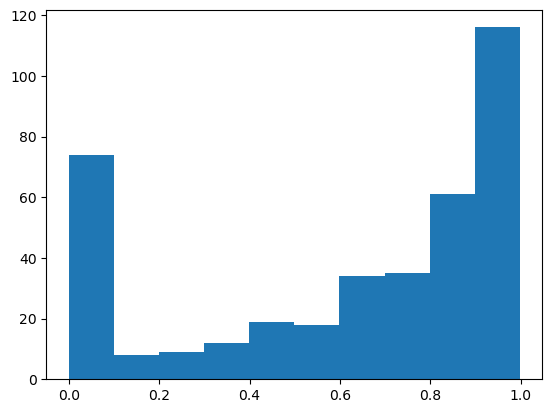

In [86]:
plt.hist(tmp.percent_spread)

np.mean(tmp.percent_spread)



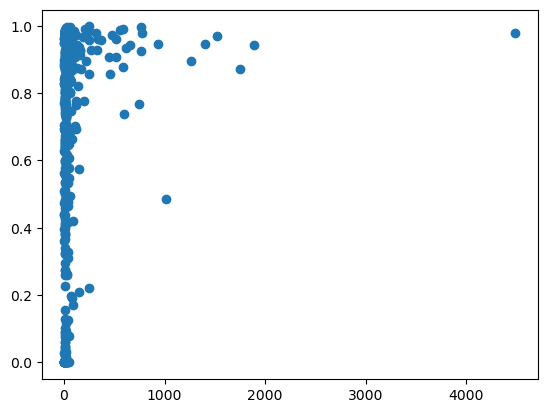

In [79]:
#plt.scatter(tmp.Final_area, tmp.percent_spread) ## Most of the area is coming from the super big fires. 
plt.scatter(tmp.Final_area, tmp.percent_spread)


In [80]:
# holi = manyfr[manyfr.fireID == 6610]
# #holi.set_index("t",inplace = True)
# holi.loc[holi.spread_line.astype(str) == "True", "spread_line"] = 1
# holi.loc[holi.spread_line.astype(str) == "False", "spread_line"] = 0

# #type(manyfr.spread_line[])
# #type(holi.spread_line)
# plt.scatter(holi.t,holi.farea, c = holi.spread_line.astype("int"))


In [81]:
# holi.loc[holi.spread_line.astype(str) == "True", "spread_line"] = 1

In [82]:
# holi

In [87]:
debug

,fireID,func_failed,log
0,4890,get_gpm_spread,"Traceback (most recent call last):\n File ""/t..."
1,5,imerge_merge,"Traceback (most recent call last):\n File ""/t..."
2,6472,imerge_merge,"Traceback (most recent call last):\n File ""/t..."
3,3329,imerge_merge,"Traceback (most recent call last):\n File ""/t..."
4,6516,get_gpm_spread,"Traceback (most recent call last):\n File ""/t..."
5,5323,get_gpm_spread,"Traceback (most recent call last):\n File ""/t..."
6,6721,imerge_merge,"Traceback (most recent call last):\n File ""/t..."
7,5375,get_gpm_spread,"Traceback (most recent call last):\n File ""/t..."
8,3705,get_gpm_spread,"Traceback (most recent call last):\n File ""/t..."
9,6153,get_gpm_spread,"Traceback (most recent call last):\n File ""/t..."


In [88]:
22/len(tmp.Id) # About 6% loss of large fires. 

0.05699481865284974

In [90]:
len(debug.log.unique())

5